In [1]:
import pandas as pd
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import dtw

from data_processing import DataIterator
from models import Autoregression

# Data from Social Competition Task
[Download dataset](http://neurotycho.brain.riken.jp/download/base/20100803S1_Social+Competition_K2_Toru+Yanagawa_csv_ECoG128-Eye9-Motion22-Event3.zip)

In [2]:
data = pd.read_csv('../data/Eye-Motion/ECoG.csv', header=0, nrows=120000)

## Формат данных
Данные представляют собой зависимость потенциалов в 128 точках мозга обезъяны от времени.   
Показатели снимаются каждую миллисекунду.  

Всего - 3697432 измерений

In [3]:
data_sample = data.loc[100000:100700, :"ECoG_ch6"]

In [4]:
data_sample.head()

,ECoG_time,ECoG_ch1,ECoG_ch2,ECoG_ch3,ECoG_ch4,ECoG_ch5,ECoG_ch6
100000,100.000,51,111,-101,107,-18,118
100001,100.001,63,118,-101,115,13,166
100002,100.002,62,137,-87,143,21,167
100003,100.003,65,146,-61,124,16,201
100004,100.004,94,167,-57,109,89,268


## Визуализация данных
Данные взяты из середины выборки

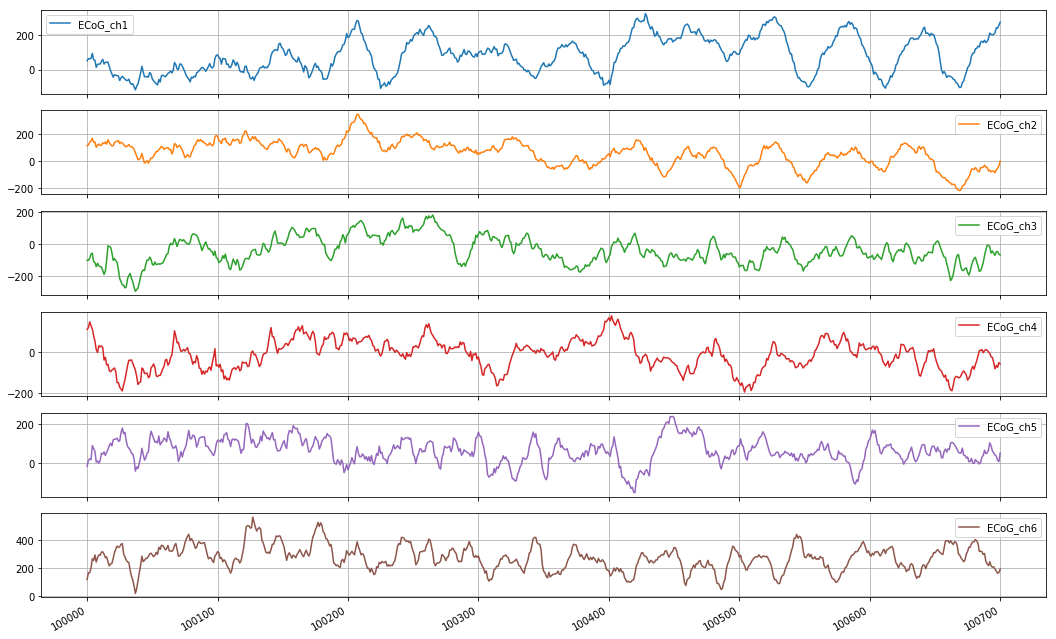

In [5]:
%matplotlib inline
data_sample.loc[:, "ECoG_ch1":].plot(subplots=True, figsize=(18, 12), grid=True);

## Проведем серию усреднений, чтобы посмотреть на тенденции измерения потенциалов
### Небольшое усреднение по трем, рядом лежащим, точкам

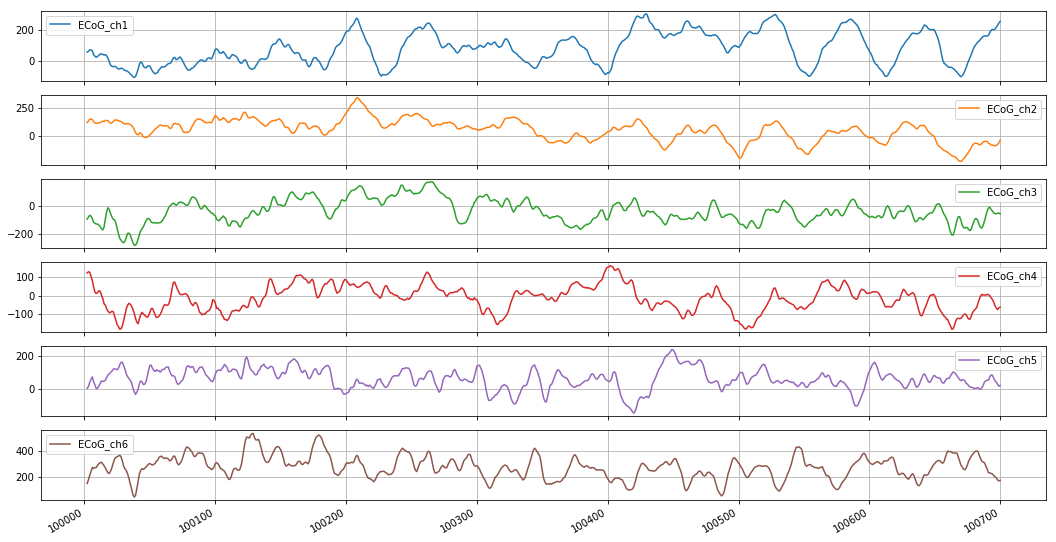

In [6]:
%matplotlib inline
data_sample.rolling(window=3).mean().loc[:, "ECoG_ch1":].plot(subplots=True, figsize=(18, 10), grid=True);

## Усреднение по 20 точкам

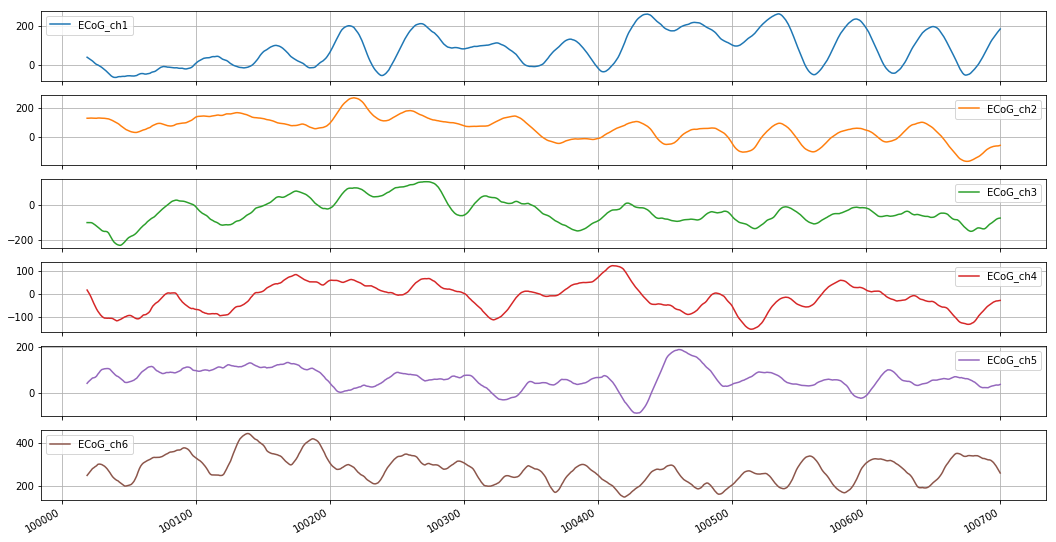

In [7]:
%matplotlib inline
data_sample.rolling(window=20).mean().loc[:, "ECoG_ch1":].plot(subplots=True, figsize=(18, 10), grid=True);

## Посмотрим на маленький отрезок данных

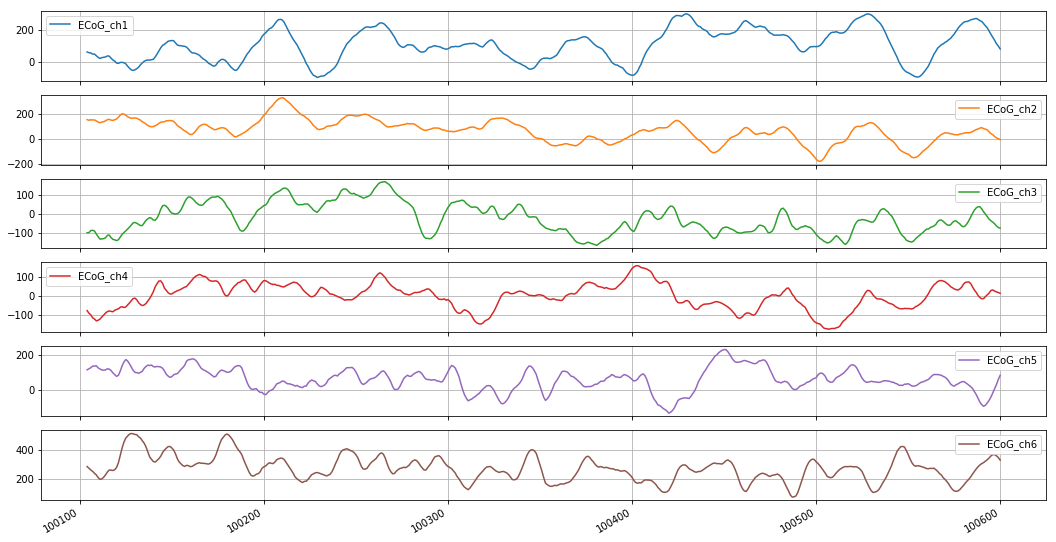

In [8]:
%matplotlib inline
data_sample.loc[100100:100600, "ECoG_ch1":].rolling(window=5).mean().loc[:, "ECoG_ch1":].plot(subplots=True, figsize=(18, 10), grid=True);

## Для большего количества измерений

In [9]:
data_sample = data.loc[:100000, :"ECoG_ch6"]

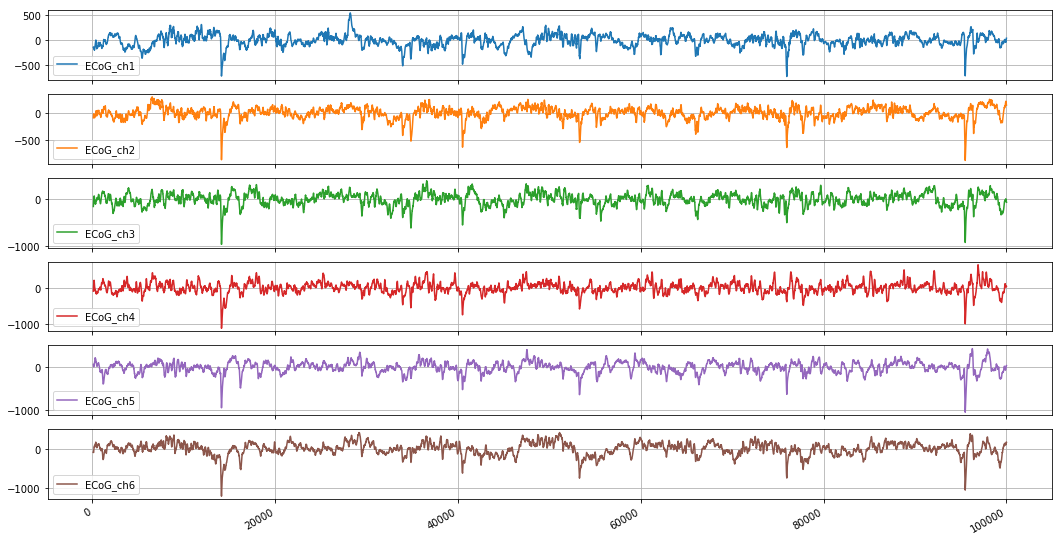

In [10]:
%matplotlib inline
data_sample.rolling(window=100).mean().loc[:, "ECoG_ch1":].plot(subplots=True, figsize=(18, 10), grid=True);

## Предположение
Можно попробовать два варианта разбиения временных рядом по 100 и по 300 точек.  
Так как в среднем, за этот период ряд претерпевает изменение значений в обе стороны.

In [11]:
#  Итератор для данных, ряды переманны
element_length = 100
data_iter = DataIterator(data_sample, element_length)

In [12]:
item = next(data_iter)

In [13]:
item.head()

,ECoG_time,ECoG_ch1,ECoG_ch2,ECoG_ch3,ECoG_ch4,ECoG_ch5,ECoG_ch6
78000,78.000,-112,51,221,114,-291,-344
78001,78.001,-107,51,253,130,-320,-340
78002,78.002,-81,67,244,131,-337,-317
78003,78.003,-95,54,201,134,-353,-335
78004,78.004,-88,61,190,117,-343,-321


## Эксперимент с DTW для первого измерения

In [14]:
x = next(data_iter).loc[:, "ECoG_ch1"]
y = next(data_iter).loc[:, "ECoG_ch1"]

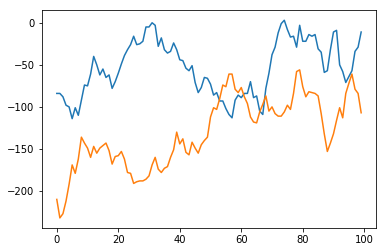

In [15]:
%matplotlib inline
time = np.linspace(0, element_length - 1, element_length)
plt.plot(time, x)
plt.plot(time, y)

In [16]:
def one_dimension_dtw(x, y):
    return dtw.dtw(x.values.reshape(-1, 1), y.values.reshape(-1, 1), dist=lambda x, y: np.linalg.norm(x - y, ord=1))

In [17]:
dist, cost, acc, path = one_dimension_dtw(x, y)

Distance: 24.935


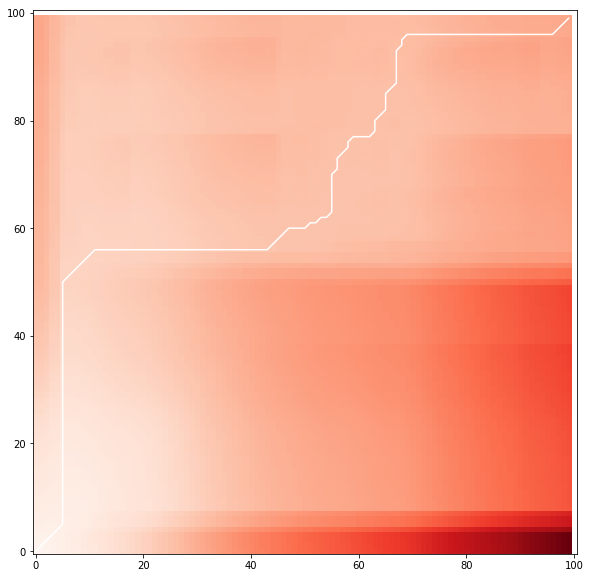

In [18]:
%matplotlib inline

plt.figure(figsize=(10,10))
plt.imshow(acc.T, origin='lower', cmap=plt.cm.Reds, interpolation='nearest')
plt.plot(path[0], path[1], 'w', )
plt.xlim((-0.5, acc.shape[0]+0.5))
plt.ylim((-0.5, acc.shape[1]+0.5))

print("Distance: {0:0.3f}".format(dist))

# Эксперимент с авторегрессионной моделью

In [19]:
import torch

In [20]:
window_size = 10
ar = Autoregression(item.loc[:, :"ECoG_ch5"], window_size)

In [21]:
ar.fit(10)

Loss: 108345.469
Loss: 4680.312
Loss: 4592.150
Loss: 4567.169
Loss: 4555.826
Loss: 4548.479
Loss: 4542.572
Loss: 4537.345
Loss: 4532.551
Loss: 4528.090
Loss: 4523.917
Loss: 4520.000
Loss: 4516.319
Loss: 4512.854
Loss: 4509.589


In [22]:
predicted = ar.predicted_series()
x = ar.data.loc[:, "ECoG_ch1" : "ECoG_ch5"].values

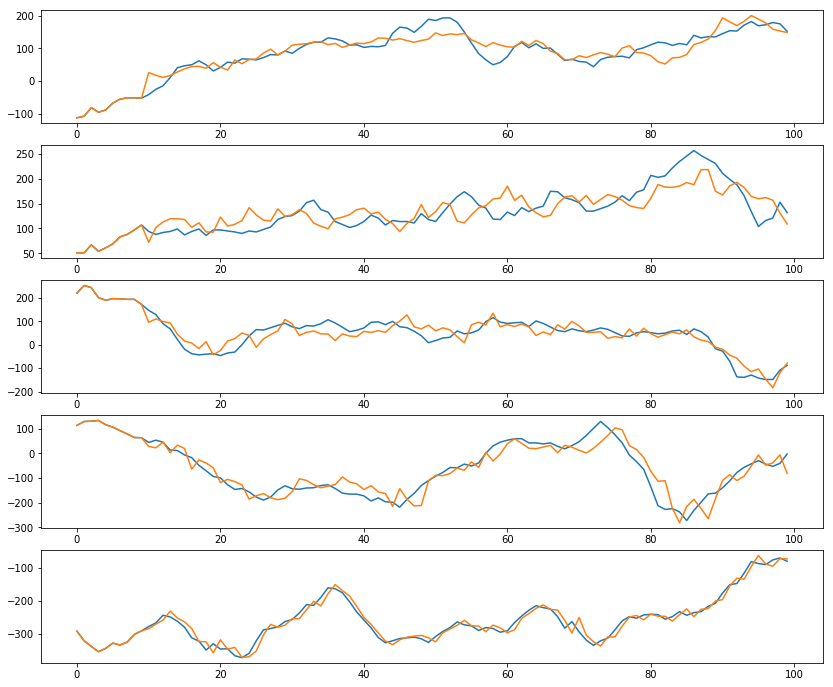

In [23]:
plt.figure(figsize=(14, 12))
time = np.linspace(0, element_length - 1, element_length)

for (i, pred) in enumerate(predicted):
    
    plt.subplot(len(predicted), 1, i+1)
    plt.plot(time, x[:,i])
    plt.plot(time, pred)

plt.show()

# Эксперименты с многомерным DTW

In [24]:
from dtw import dtw as dtw_custom

In [25]:
x = next(data_iter)
y = next(data_iter)

In [26]:
x = x.loc[:, "ECoG_ch1":"ECoG_ch3"].values
y = y.loc[:, "ECoG_ch1":"ECoG_ch3"].values

Заметим, что достаточно передать функцию, которая определяет расстояния между векторами

In [27]:
distance = lambda x, y: np.linalg.norm(x - y)

In [28]:
%time
dist, cost, acc, path = dtw_custom(x, y, distance)

Wall time: 0 ns


Distance: 129.412


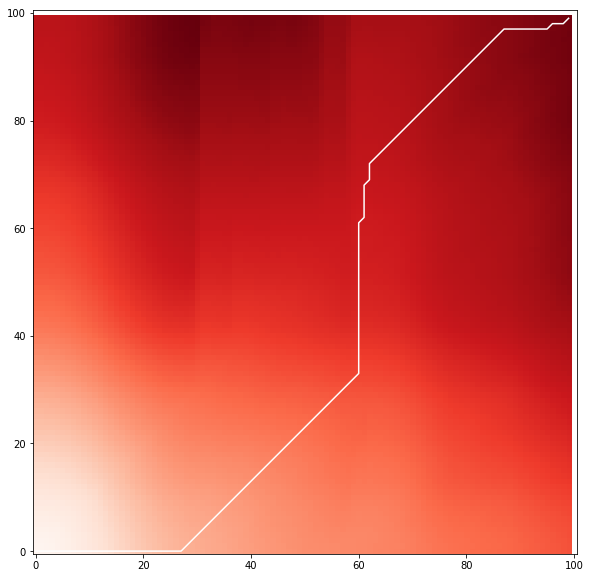

In [29]:
%matplotlib inline

plt.figure(figsize=(10,10))
plt.imshow(acc.T, origin='lower', cmap=plt.cm.Reds, interpolation='nearest')
plt.plot(path[0], path[1], 'w', )
plt.xlim((-0.5, acc.shape[0]+0.5))
plt.ylim((-0.5, acc.shape[1]+0.5))

print("Distance: {0:0.3f}".format(dist))

## Различные нормы

### Cosine

In [30]:
from scipy.spatial import distance

In [31]:
%time
dist, cost, acc, path = dtw.dtw_ln(x, y, distance.cosine)

Wall time: 0 ns


Distance: 0.519


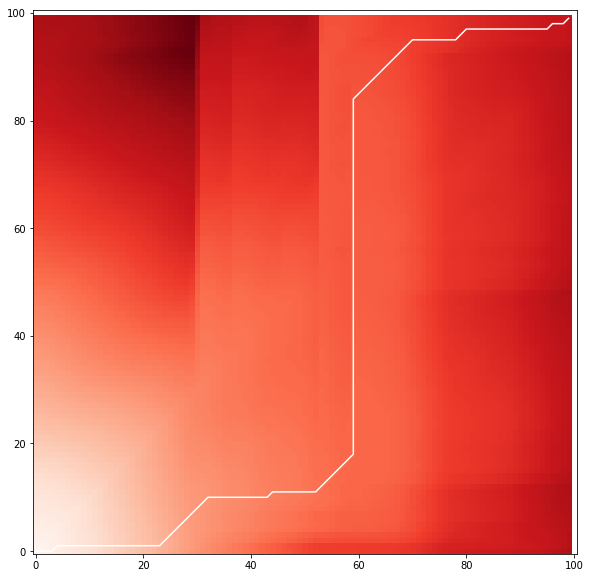

In [32]:
%matplotlib inline

plt.figure(figsize=(10,10))
plt.imshow(acc.T, origin='lower', cmap=plt.cm.Reds, interpolation='nearest')
plt.plot(path[0], path[1], 'w', )
plt.xlim((-0.5, acc.shape[0]+0.5))
plt.ylim((-0.5, acc.shape[1]+0.5))

print("Distance: {0:0.3f}".format(dist))

In [33]:
from scipy.cluster.hierarchy import dendrogram, linkage
next_prepared = lambda it: next(it).loc[:, "ECoG_ch1":"ECoG_ch3"].values.reshape(1, -1)[0]

In [34]:
x = next(data_iter)
y = next(data_iter)
x = x.loc[:, "ECoG_ch1":"ECoG_ch3"].values
y = y.loc[:, "ECoG_ch1":"ECoG_ch3"].values
shape = x.shape

dtw_dist = lambda x, y: (dtw_custom(x.reshape(shape), y.reshape(shape), distance.chebyshev)[0])

In [35]:
X = np.array([next_prepared(data_iter) for i in range(40)])

In [36]:
Z = linkage(X, metric=dtw_dist)

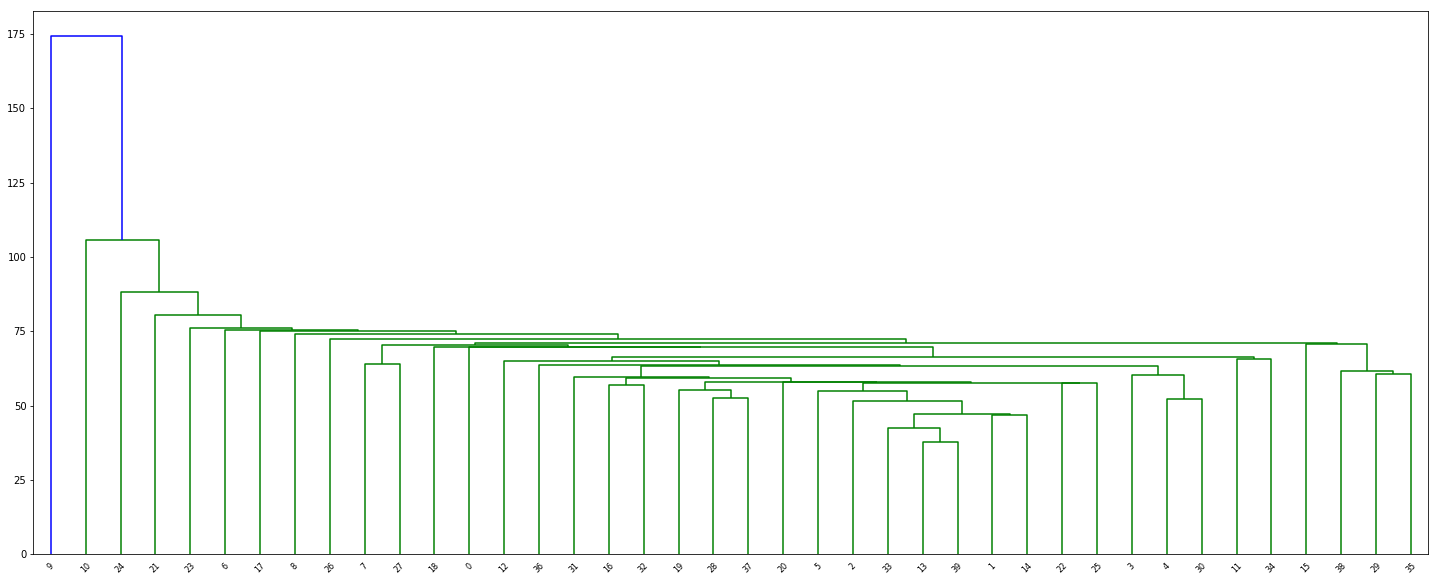

In [37]:
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(Z)